## Mapaton2023 Cat4 
### EspiritusMaquina

![:o](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTKqyWbTjGDl4toc-aKgAYbzkS9GQC4eoIPxFfVQ9azUshTOntx0j5d4utiBFTp6AwJJ88&usqp=CAU)


## Carga de datos

In [45]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D,Dropout,Conv2DTranspose, UpSampling2D, concatenate
from tensorflow.keras.models import load_model

# Cargar el dataset de entrenamiento
data_folder = "./DatasetPeruSat1"
# cargar imagenes de entrenamiento
image_folder = os.path.join(data_folder, "train_images_256")
#cargar mascaras de entrenamiento
mask_folder = os.path.join(data_folder, "train_masks_256")

# Obtener lista de nombres de archivo para las imágenes
image_files = os.listdir(image_folder)

print("Numero de Imagenes de entrenamiento: ", len(image_files))
print("Numero de Mascaras de entrenamiento: ", len(os.listdir(mask_folder)))


Numero de Imagenes de entrenamiento:  555
Numero de Mascaras de entrenamiento:  555


## Preprocesamiento de Datos

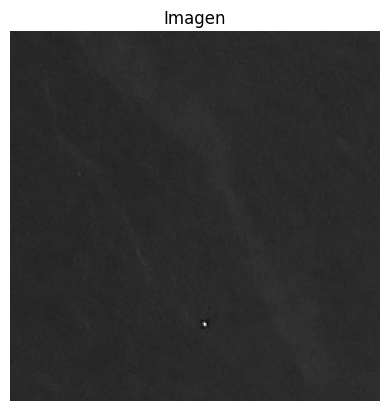

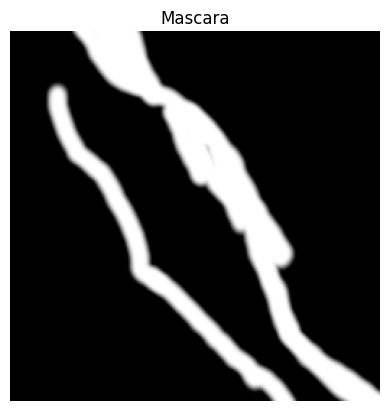

In [46]:

# Redimensionar todas las imágenes a un tamaño específico
image_size = (256, 256)

# listas para almacenar las imágenes y sus máscaras
images = []
masks = []

# cargar imagenes y mascaras
for filename in image_files:
    image_path = os.path.join(image_folder, filename)
    mask_path = os.path.join(mask_folder, filename)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, image_size)
    mask = cv2.resize(mask, image_size)

    # Normalizar las imágenes y máscaras para que los valores estén entre 0 y 1
    image = image / 255.0
    mask = mask / 255.0

    images.append(image)
    masks.append(mask)


# Convertir las listas de imágenes y máscaras a arreglos numpy
images = np.array(images)
masks = np.array(masks)


# Agregar una dimensión adicional para el canal (ya que las imágenes están en escala de grises)
images = np.expand_dims(images, axis=-1)
masks = np.expand_dims(masks, axis=-1)




# plotear una imagen y su máscara de ejemplo
def plotImage (image,title):
    image = cv2.imread( image, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, image_size)
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=0)
    image = np.expand_dims(image, axis=-1)
    plt.imshow(image[0, :, :, 0], cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

    
#imagen
plotImage("./DatasetPeruSat1/train_images_256/20220123_corte3_part11.tiff","Imagen")

#mascara
plotImage("./DatasetPeruSat1/train_masks_256/20220123_corte3_part11.tiff","Mascara")




## Arquitectura de Red Neuronal Convolucional: U-net

In [47]:


def unet(input_layer=(256, 256, 1), start_neurons=16):
    inputs = Input(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(inputs)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)
    
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    model = Model(inputs=inputs, outputs=output_layer)
    
    return model



## Carga y Entrenamiento del modelo
- save =  para entrenar por primera vez
- load = para cargar un modelo pre-entrenado

In [48]:

# definir el tipo de operacion a realizar
# save = entrenar y guardar el modelo
# load = cargar el modelo pre-entrenado
save_load = "load"

#nombre del modelo pre-entrenado
model_name = "model_200E_30N_perusat.h5"
# model_name = "model_100E_32N.h5"

#definir el numero de neuronas y epocas
neuronas = 32
epocas = 10

#modelo de la red
model  = None


if save_load == "save":
    model = unet(input_layer=(256,256,1), start_neurons=neuronas)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(images, masks, batch_size=8, epochs=epocas, validation_split=0.2)
    model.save("./DataSave/models/" + model_name)
else:
    model = tf.keras.models.load_model("./DataSave/models/" + model_name)

#plot de caracteristicas
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 30)         300       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 30)         8130      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 30)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

## Test de Modelos


- Se realiza una comparación con los modelos pre-entrenados con imagenes :
    - Satelitales Sentinel de distintos derrames en el mundo
    - PeruSat-1 del derrame de Ventanilla en Perú

In [53]:

model_SAR_name = "model_100E_32N.h5"
model_PER1_name = "model_200E_30N_perusat.h5"

# Cargar los modelos pre-entrenados 
model_SAR = tf.keras.models.load_model("./DataSave/models/" + model_SAR_name)
model_PER1 = tf.keras.models.load_model("./DataSave/models/" + model_PER1_name)



# Cargar el conjunto de datos de prueba y las máscaras correspondientes

# Cargar el dataset de entrenamiento
data_folder = "./DatasetPeruSat1"
# cargar imagenes de entrenamiento
image_folder = os.path.join(data_folder, "test_images_256")
#cargar mascaras de entrenamiento
mask_folder = os.path.join(data_folder, "test_masks_256")

# Obtener lista de nombres de archivo para las imágenes
image_files = os.listdir(image_folder)

# listas para almacenar las imágenes y sus máscaras
test_images = []
test_masks = []

# cargar imagenes y mascaras
for filename in image_files:
    image_path = os.path.join(image_folder, filename)
    mask_path = os.path.join(mask_folder, filename)

    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    image = cv2.resize(image, image_size)
    mask = cv2.resize(mask, image_size)

    # Normalizar las imágenes y máscaras para que los valores estén entre 0 y 1
    image = image / 255.0
    mask = mask / 255.0

    test_images.append(image)
    test_masks.append(mask)


# Convertir las listas de imágenes y máscaras a arreglos numpy
test_images = np.array(test_images)
test_masks = np.array(test_masks)


# Agregar una dimensión adicional para el canal (ya que las imágenes están en escala de grises)
test_images = np.expand_dims(test_images, axis=-1)
test_masks = np.expand_dims(test_masks, axis=-1)

print("Numero de Imagenes de entrenamiento: ", len(test_images))
print("Numero de Mascaras de entrenamiento: ", len(test_masks))



# Realizar predicciones con ambos modelos en el conjunto de prueba
predictions_model_SAR = model_SAR.predict(test_images)
predictions_model_PER1 = model_PER1.predict(test_images)

# Realizar (MERGE) el ensamblaje de las predicciones de ambos modelos
predictions_model_MERG = (predictions_model_SAR * 0.2) + (predictions_model_PER1 * 0.8)


# Convertir las predicciones a máscaras binarias (0 o 1) usando un umbral
# Por ejemplo, un píxel con probabilidad mayor o igual a 0.5 se considera como 1, de lo contrario, 0.
threshold = 0.5
predictions_model_SAR_binary = (predictions_model_SAR >= threshold).astype(int)
predictions_model_PER1_binary = (predictions_model_PER1 >= threshold).astype(int)
predictions_model_MERG_binary = (predictions_model_MERG >= threshold).astype(int)

# Calcular la precisión para cada modelo comparando las predicciones con las máscaras reales
accuracy_model_SAR = np.mean(predictions_model_SAR_binary == test_masks)
accuracy_model_PER1 = np.mean(predictions_model_PER1_binary == test_masks)
accuracy_model_MERG = np.mean(predictions_model_MERG_binary == test_masks)


Numero de Imagenes de entrenamiento:  132
Numero de Mascaras de entrenamiento:  132
5/5 [==============================] - 9s 2s/step


### Visualización de Comparación

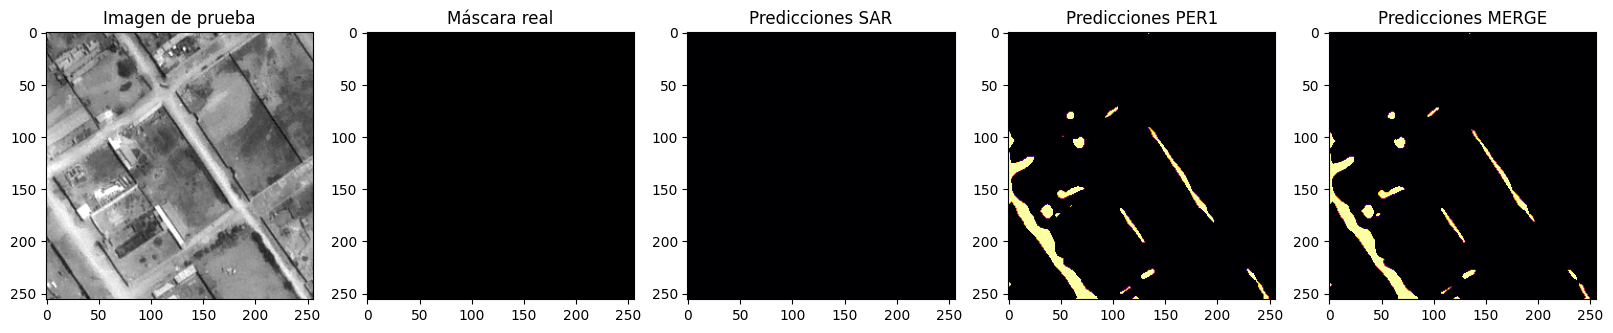

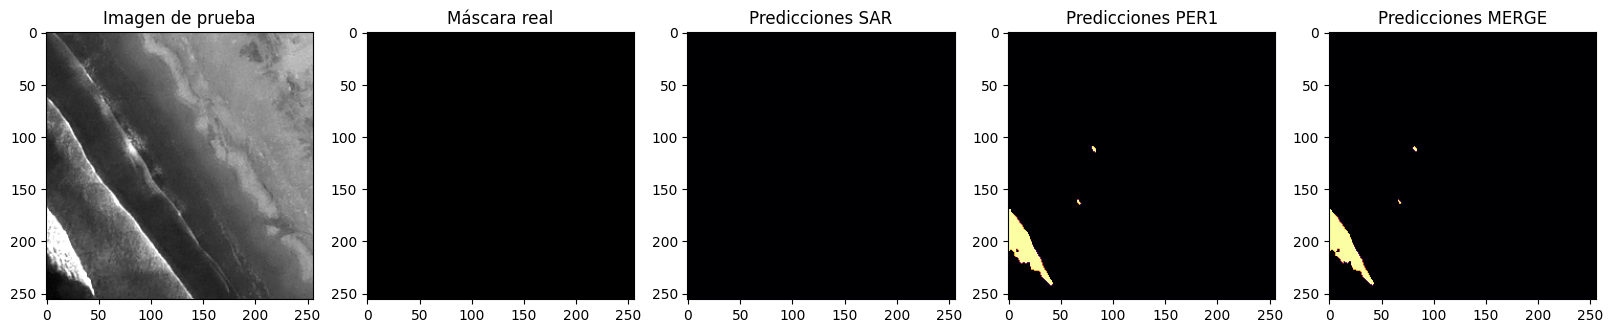

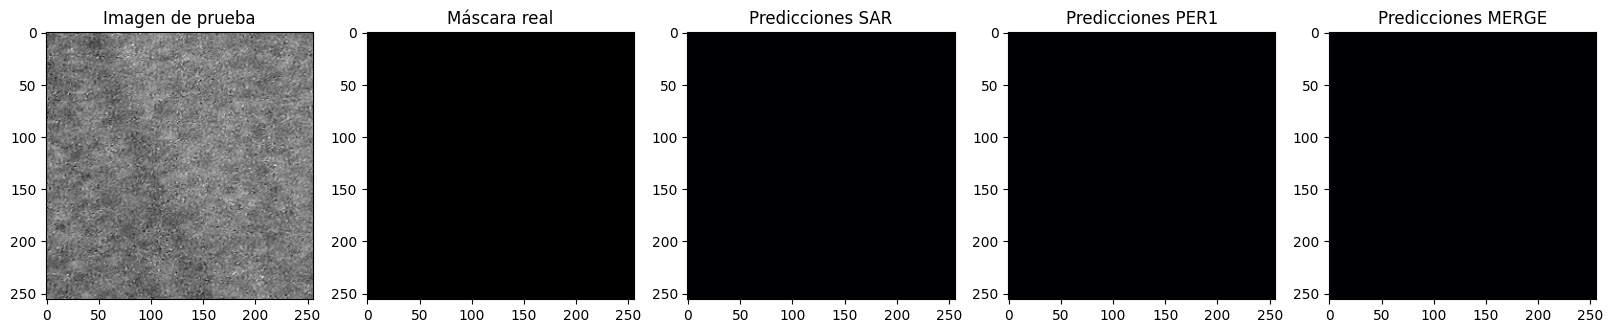

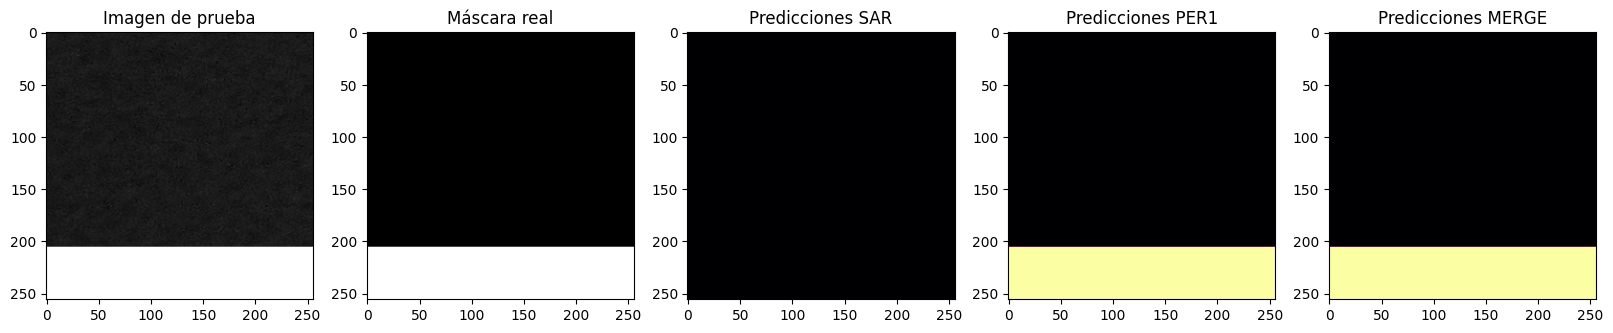

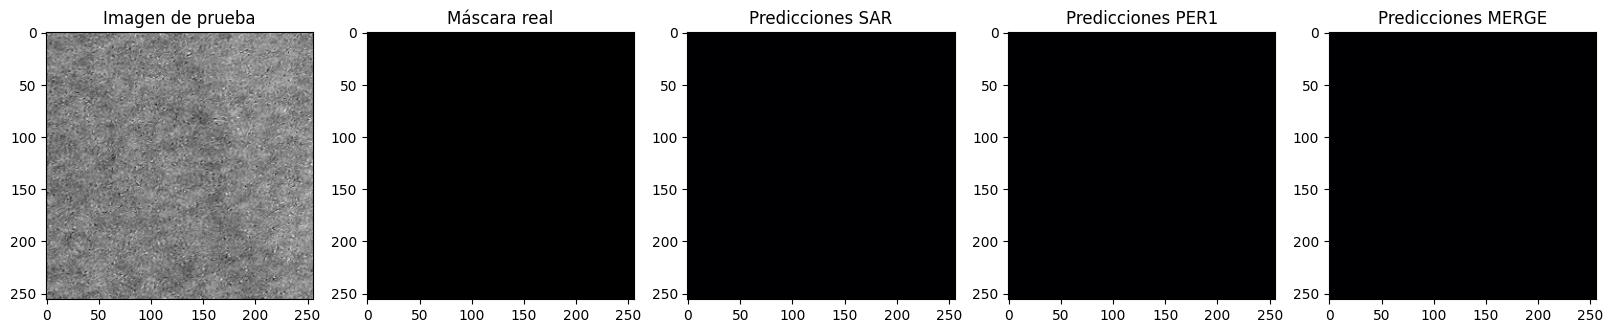

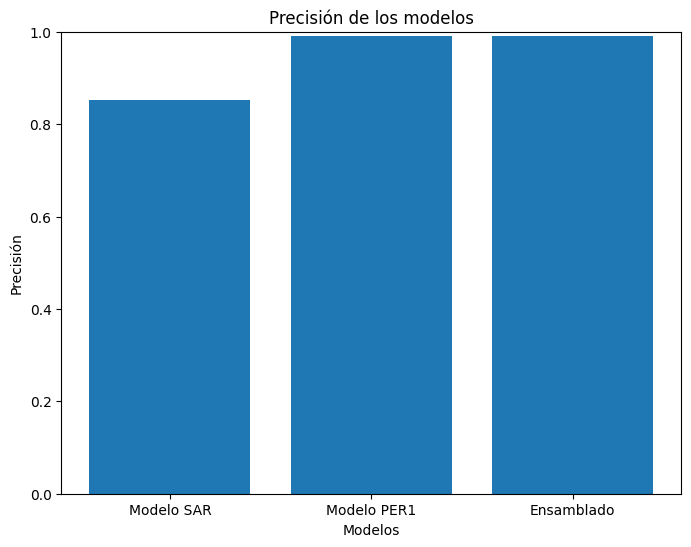

Precisión del modelo SAR: 0.8525099320845171
Precisión del modelo PER1: 0.9907095938017874
Precisión del ensamblaje de ambos modelos: 0.990929921468099


In [54]:

# Visualizar algunas imágenes de prueba junto con sus máscaras reales y predicciones de cada modelo




num_images_to_visualize = 5

for i in range(num_images_to_visualize):
    plt.figure(figsize=(20, 5))
    
    # Imagen de prueba
    plt.subplot(1, 5, 1)
    plt.imshow(test_images[i].squeeze(), cmap='gray')
    plt.title('Imagen de prueba')
    
    # Máscara real
    plt.subplot(1, 5, 2)
    plt.imshow(test_masks[i].squeeze(), cmap='gray')
    plt.title('Máscara real')
    
    # Predicciones del modelo SAR
    plt.subplot(1, 5, 3)
    plt.imshow(predictions_model_SAR_binary[i].squeeze(), cmap='inferno')
    plt.title('Predicciones SAR')
    
    # Predicciones del modelo PER1
    plt.subplot(1, 5, 4)
    plt.imshow(predictions_model_PER1_binary[i].squeeze(), cmap='inferno')
    plt.title('Predicciones PER1')

    # Predicciones del modelo emsamblado
    plt.subplot(1, 5, 5)
    plt.imshow(predictions_model_MERG_binary[i].squeeze(), cmap='inferno')
    plt.title('Predicciones MERGE')

    plt.show()



# Gráfico de barras para comparar la precisión de los modelos
model_names = ['Modelo SAR', 'Modelo PER1', 'Ensamblado']
accuracy_values = [accuracy_model_SAR, accuracy_model_PER1, accuracy_model_MERG]

plt.figure(figsize=(8, 6))
plt.bar(model_names, accuracy_values)
plt.ylim(0, 1)  # Asegura que el eje Y se limite de 0 a 1 para la precisión
plt.title('Precisión de los modelos')
plt.xlabel('Modelos')
plt.ylabel('Precisión')
plt.show()

# Imprimir los resultados
print("Precisión del modelo SAR:", accuracy_model_SAR)
print("Precisión del modelo PER1:", accuracy_model_PER1)
print("Precisión del ensamblaje de ambos modelos:", accuracy_model_MERG)

## Ejemplo Práctico

1/1 [==============================] - 0s 239ms/step


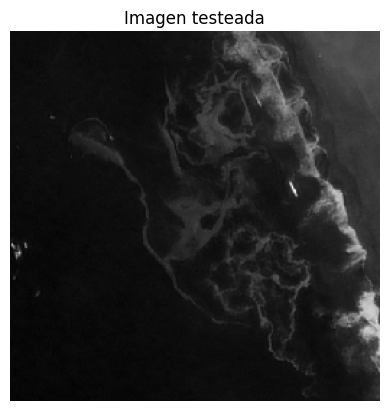

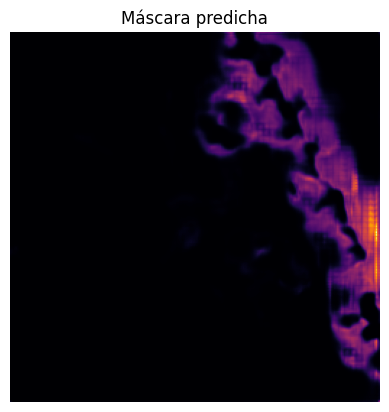

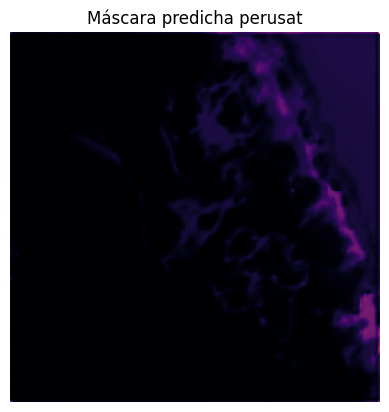

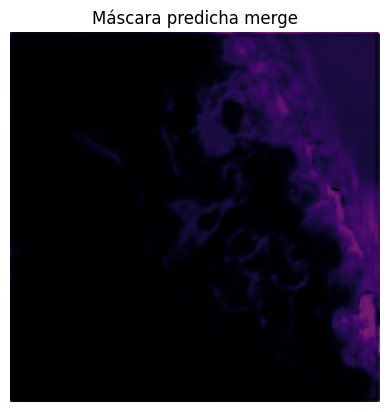

In [55]:

# ejemplo de predicción
# image_path = "./dataset_perusat_nuevo/train_images_256/202202cortado3_gray_gray_part34.tif"
# image_path = "./dataset_perusat_nuevo/train_images_256/20220123_corte1_part3.tiff"

# image_path = "./dataset_perusat_nuevo/train_images_256/20220208recortado2_gray_gray_part329.tif"

#construcciones
# image_path = "./DatasetPeruSat/train_images_256/20220123_corte1_part2.tiff"


# image_path = "./DatasetPeruSat/train_images_256/202202cortado4_gray_gray_part1.tif"


image_path = "ejemplo.png"

#avion 1
# image_path = "ejemplo3.tif"

test_image = cv2.imread( image_path, cv2.IMREAD_GRAYSCALE)


test_image = cv2.resize(test_image, image_size)
test_image = test_image.astype('float32') / 255.0
test_image = np.expand_dims(test_image, axis=0)
test_image = np.expand_dims(test_image, axis=-1)


##########################################################
# Carga el segundo modelo
model1 = tf.keras.models.load_model("./DataSave/models/model_100E_32N.h5")
model2 = tf.keras.models.load_model("./DataSave/models/model_200E_30N_perusat.h5")

predicted_mask1= model1.predict(test_image)  # Asegúrate de tener los datos de prueba (test_data)
predicted_mask2 = model2.predict(test_image)

# Promedia las predicciones
predicted_mask = predicted_mask1*0.2 + predicted_mask2*0.8

# Encuentra las intersecciones entre las predicciones
# predicted_mask  = np.multiply(predicted_mask1*0.2, predicted_mask2*0.8)
# predicted_mask = predictions_model
#############################################################

# predicted_mask = model.predict(test_image)


# plt.figure(figsize=(20, 5))

# Mostrar la imagen testeada
plt.imshow(test_image[0, :, :, 0], cmap='gray')
plt.title('Imagen testeada')
plt.axis('off')
plt.show()


# image_path = "./DatasetPeruSat/train_masks_256/202202cortado4_gray_gray_part1.tif"
# mask_image = cv2.imread( image_path, cv2.IMREAD_GRAYSCALE)

# mask_image = cv2.resize(mask_image, image_size)
# mask_image = mask_image.astype('float32') / 255.0
# mask_image = np.expand_dims(mask_image, axis=0)
# mask_image = np.expand_dims(mask_image, axis=-1)

# # Mostrar mascara real
# plt.imshow(mask_image[0, :, :, 0], cmap='gray')
# plt.title('Mask real')
# plt.axis('off')
# plt.show()



#Mostrar la máscara predicha
# predicted_mask = predicted_mask.squeeze()
predicted_mask1 = predicted_mask1.squeeze()
plt.imshow(predicted_mask1, cmap='inferno')
plt.title('Máscara predicha')
plt.axis('off')
plt.show()


#Mostrar la máscara predicha
predicted_mask2 = predicted_mask2.squeeze()
plt.imshow(predicted_mask2, cmap='inferno')
plt.title('Máscara predicha perusat')
plt.axis('off')
plt.show()

#Mostrar la máscara predicha
predicted_mask = predicted_mask.squeeze()
plt.imshow(predicted_mask, cmap='inferno')
plt.title('Máscara predicha merge')
plt.axis('off')



plt.show()



